In [1]:
from loss import MSELoss, CrossEntropyLoss
from sgd import SGD
from linear import Linear
from sequential import Sequential
from activation import ReLU, Tanh
from math import pi
from torch import empty, set_grad_enabled
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


In [2]:
import torch
import math

from torch import optim
from torch import Tensor
from torch import nn

In [3]:

def generate_disc_set(nb, one_hot=False):
    input = empty(nb, 2).uniform_(0, 1)
    target = input.add(-0.5).pow(2).sum(1).sub(1 /(2*pi)).sign().add(1).div(2).long()
    if not one_hot:
        target = target.new_zeros(
            target.size(0), 
            input.size(1)).scatter(1, target.view(-1, 1), 1)
    return input, target

###############################################################################

def compute_nb_errors(model, data_input, data_target, mini_batch_size=100, one_hot=False):
    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(axis=1)
        for k in range(mini_batch_size):
            target = data_target[b + k]
            if not one_hot:
                target = target.argmax()
            if target != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors


def train_model(model, train_input, train_target, it, mini_batch_size=100, one_hot=False):
    creterion = MSELoss(model) if not one_hot else CrossEntropyLoss(model)
    lr = 5e-2 if not one_hot else 1e-3
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.5)
    nb_epochs = 100
    l = []

    for _ in range(nb_epochs):
        batch_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = creterion(output, train_target.narrow(0, b, mini_batch_size))
            
            model.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss = loss + batch_loss
        l.append(batch_loss)
    matrix_loss_our[:,it] = l
    #plt.plot(range(nb_epochs), l, label = 'Our Class')

    
    
def train_model2(model, train_input, train_target, it, one_hot=False):
    if not one_hot:
        train_input = train_input.to(torch.float32)
        train_target = train_target.to(torch.float32)
    criterion = nn.MSELoss() if not one_hot else nn.CrossEntropyLoss()
    lr = 5e-2 if not one_hot else 1e-3
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    nb_epochs = 100

    l = []
    for _ in range(nb_epochs):
        batch_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss = loss + batch_loss
        l.append(batch_loss)
    matrix_loss_pytorch[:,it] = l
    #plt.plot(range(nb_epochs), l, label = 'Pytorch')
    
    
    


In [4]:
#Compare performances
import time

num_it = 100
vect_it = np.arange(0,num_it,1)
vect_our_train_errors = np.ones((num_it,1))
vect_our_test_errors = np.ones((num_it,1))
vect_pytorch_train_errors = np.ones((num_it,1))
vect_pytorch_test_errors = np.ones((num_it,1))
matrix_loss_our = np.ones((100, num_it))
matrix_loss_pytorch = np.ones((100, num_it))
vect_time_our = np.ones((num_it, 1))
vect_time_pytorch = np.ones((num_it, 1))

for it in vect_it:
    set_grad_enabled(False)
    one_hot = False
    train_input, train_target = generate_disc_set(1000, one_hot)
    test_input, test_target = generate_disc_set(1000, one_hot)
    mean, std = train_input.mean(), train_input.std()
    train_input.sub_(mean).div_(std)
    test_input.sub_(mean).div_(std)

    time1 = time.time()
    model = Sequential(
        Linear(2, 25),
        ReLU(),
        Linear(25, 2)
    )

    train_model(model, train_input, train_target, it, one_hot=one_hot)
    time2 = time.time()
    print('Our: train_error {:.02f}% test_error {:.02f}%'.format(
           compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100,
            compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100))
    #plt.savefig('prova.png')
    vect_our_train_errors[it] = compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100
    vect_our_test_errors[it] = compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100
    vect_time_our[it] = time2 - time1
    ######################################################################
   
    set_grad_enabled(True)
    #mean, std = train_input.mean(), train_input.std()
    #train_input.sub_(mean).div_(std)
    #test_input.sub_(mean).div_(std)

    mini_batch_size = 100
    time1 = time.time()
    model2 = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 2)
        )
    train_model2(model2, train_input, train_target, it, one_hot=one_hot)
    time2 = time.time()
    print('Pytorch: train_error {:.02f}% test_error {:.02f}%'.format(
           compute_nb_errors(model2, train_input, train_target) / train_input.size(0) * 100,
            compute_nb_errors(model2, test_input, test_target) / test_input.size(0) * 100))

    vect_pytorch_train_errors[it] = compute_nb_errors(model2, train_input, train_target) / train_input.size(0) * 100
    vect_pytorch_test_errors[it] = compute_nb_errors(model2, test_input, test_target) / test_input.size(0) * 100
    vect_time_pytorch[it] = time2 - time1

#plt.xlabel('# epochs')
#plt.ylabel('Loss (MSE)')
#plt.legend()
#plt.show()



Our: train_error 3.90% test_error 4.20%
Pytorch: train_error 1.50% test_error 1.40%
Our: train_error 5.30% test_error 4.90%
Pytorch: train_error 4.60% test_error 3.10%
Our: train_error 1.80% test_error 2.70%
Pytorch: train_error 1.80% test_error 2.50%
Our: train_error 3.80% test_error 3.70%
Pytorch: train_error 2.20% test_error 2.50%
Our: train_error 4.60% test_error 5.70%
Pytorch: train_error 3.60% test_error 3.90%
Our: train_error 3.30% test_error 4.60%
Pytorch: train_error 2.20% test_error 1.70%
Our: train_error 3.00% test_error 4.40%
Pytorch: train_error 2.10% test_error 3.60%
Our: train_error 3.80% test_error 4.20%
Pytorch: train_error 2.10% test_error 2.80%
Our: train_error 3.50% test_error 6.00%
Pytorch: train_error 2.50% test_error 4.80%
Our: train_error 3.10% test_error 3.10%
Pytorch: train_error 2.70% test_error 2.60%
Our: train_error 2.80% test_error 3.20%
Pytorch: train_error 1.70% test_error 1.80%
Our: train_error 4.30% test_error 4.90%
Pytorch: train_error 3.10% test_erro

In [5]:

mean_our_train_errors = vect_our_train_errors.mean()
mean_our_test_errors = vect_our_test_errors.mean()
mean_pytorch_train_errors = vect_pytorch_train_errors.mean()
mean_pytorch_test_errors = vect_pytorch_test_errors.mean()

#matrix_loss_our = np.ones((100, num_it))
#matrix_loss_pytorch = np.ones((100, num_it))
#vect_time_our = np.ones((num_it, 1))
#vect_time_pytorch = np.ones((num_it, 1))

In [6]:
print('Our: \nmean train_error {:.02f}% \nmean train std error {:.02f}%: \n \nmean test_error {:.02f}% \nmean test std error {:.02f}%'.format(
           vect_our_train_errors.mean(), vect_our_train_errors.std(),
            vect_our_test_errors.mean(), vect_our_test_errors.std()))
print('\nPyTorch: \nmean train_error {:.02f}% \nmean train std error {:.02f}% \nmean test_error {:.02f}% \nmean test std error {:.02f}%'.format(
           vect_pytorch_train_errors.mean(), vect_pytorch_train_errors.std(),
            vect_pytorch_test_errors.mean(), vect_pytorch_test_errors.std()))
print('\nmean time to train: \nOur =  {:.02f} s,  \nPytorch = {:.02f} s'.format(
           vect_time_our.mean(), vect_time_pytorch.mean()))


Our: 
mean train_error 3.61% 
mean train std error 0.89%: 
 
mean test_error 4.08% 
mean test std error 1.09%

PyTorch: 
mean train_error 2.41% 
mean train std error 0.91% 
mean test_error 2.85% 
mean test std error 0.99%

mean time to train: 
Our =  0.53 s,  
Pytorch = 0.92 s


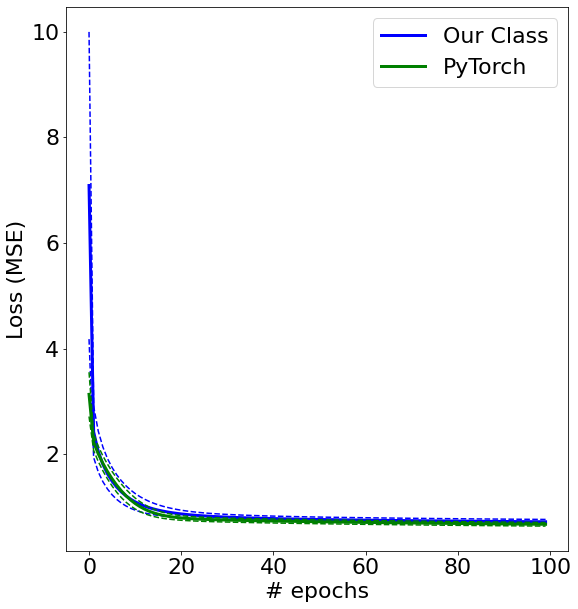

In [7]:
central_our = matrix_loss_our.mean(axis = 1)
up_our = central_our + matrix_loss_our.std(axis = 1)
down_our = central_our - matrix_loss_our.std(axis = 1)

central_pytorch = matrix_loss_pytorch.mean(axis = 1)
up_pytorch = central_pytorch + matrix_loss_pytorch.std(axis = 1)
down_pytorch = central_pytorch - matrix_loss_pytorch.std(axis = 1)

plt.figure(figsize=(9, 10))
plt.plot(range(100), up_our, linewidth = 1.5, linestyle = '--', color = 'b')
plt.plot(range(100), central_our, label = 'Our Class', linewidth = 3, linestyle = '-', color = 'b')
plt.plot(range(100), down_our, linewidth = 1.5, linestyle = '--', color = 'b')

plt.plot(range(100), up_pytorch, linewidth = 1.5, linestyle = '--', color = 'g')
plt.plot(range(100), central_pytorch, label = 'PyTorch', linewidth = 3, linestyle = '-', color = 'g')
plt.plot(range(100), down_pytorch, linewidth = 1.5, linestyle = '--', color = 'g')

plt.xlabel('# epochs', size = 22)
plt.ylabel('Loss (MSE)', size = 22)
plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)
plt.legend(fontsize = 22)
plt.savefig("loss_plots_2.pdf")
plt.show()



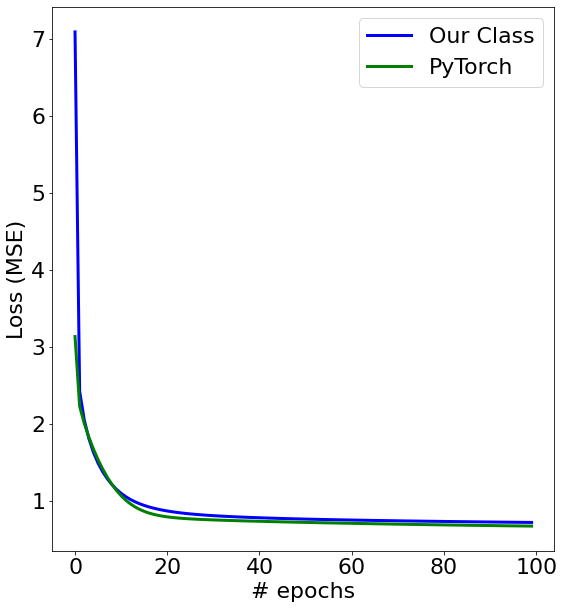

In [8]:
central_our = matrix_loss_our.mean(axis = 1)

central_pytorch = matrix_loss_pytorch.mean(axis = 1)

plt.figure(figsize=(9, 10))
plt.plot(range(100), central_our, label = 'Our Class', linewidth = 3, linestyle = '-', color = 'b')

plt.plot(range(100), central_pytorch, label = 'PyTorch', linewidth = 3, linestyle = '-', color = 'g')

plt.xlabel('# epochs', size = 22)
plt.ylabel('Loss (MSE)', size = 22)
plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)
plt.legend(fontsize = 22)
plt.savefig("loss_plots_2.pdf")
plt.show()

